# Molecular generation when the pharmacophore is given with ligand

In [ ]:
import torch
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True
from model.pgmg import PGMG

from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
import pickle
import einops

In [ ]:
import torch
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True
from model.pgmg import PGMG

from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
import pickle
import einops

In [2]:

def sample_probability(elment_array,plist,N):
    Psample=[]
    n=len(plist)
    index=int(random.random()*n)
    mw=max(plist)
    beta=0.0
    for i in range(N):                  ##核心算法
        beta=beta+random.random()*2.0*mw
        while beta > plist[index]:
            beta=beta-plist[index]
            index=(index+1)%n
        Psample.append(elment_array[index])
    cresult=Counter(Psample)
    psam=[cresult[x] for x in plist]
    pe=[x*N for x in plist]
    #print(cresult)
    
    return Psample
def cal_dist(mol,start_atom,end_tom):
    list_=[]
    list_.append(start_atom)
    seen=set()
    seen.add(start_atom)
    parent={start_atom:None}
    nei_atom=[]
    bond_num = mol.GetNumBonds()
    while (len(list_)>0):    
        vertex=(list_[0])
        del(list_[0])
        nei_atom=([n.GetIdx() for n in mol.GetAtomWithIdx(vertex).GetNeighbors()])
        for w in nei_atom:
             if w not in seen:
                list_.append(w)
                seen.add(w)
                parent[w]=vertex
    path_atom=[]
    while end_tom!=None:
        path_atom.append(end_tom)
        end_tom=parent[end_tom]
    nei_bond=[]
    for i in range(bond_num):
        nei_bond.append((mol.GetBondWithIdx(i).GetBondType().name,mol.GetBondWithIdx(i).GetBeginAtomIdx(),mol.GetBondWithIdx(i).GetEndAtomIdx()))    
    bond_collection=[]    
    for idx in range(len(path_atom)-1):
        bond_start=path_atom[idx]
        bond_end=path_atom[idx+1]
        for bond_type in nei_bond:
            if len(list(set([bond_type[1],bond_type[2]]).intersection(set([bond_start,bond_end]))))==2:
                bond_=bond_type[0]
                if [bond_,bond_type[1],bond_type[2]] not in bond_collection:
                    bond_collection.append([bond_,bond_type[1],bond_type[2]])
    dist=0
    for elment in bond_collection:
        if elment[0]=='SINGLE':
            dist=dist+1
        elif elment[0]=='DOUBLE':
            dist=dist+0.87
        elif elment[0]=='AROMATIC':
            dist=dist+0.91
        else:
            dist=dist+0.78
    return dist


ELEM_LIST = [[1],[2],[3],[4],[5],[6],[0]]

def _onek_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def _atom_features(atom):
    return (torch.HalfTensor(_onek_encoding_unk(atom, ELEM_LIST)))

def ligand_to_pharmacophore(smiels,unique_index_filter_sort):
    dgl_list=[]
    mol=Chem.MolFromSmiles(smiles)
    unique_index_filter_sort=[[[2], (6,)],[[1], (0, 1, 2, 3, 4, 5)],[[3], (11,)],[[3], (23,)]]

    type_list=[]
    size_=[]
    e_list=[]
    position_matrix=np.zeros((len(unique_index_filter_sort),len(unique_index_filter_sort)))
    for mol_phco_i in range(len(unique_index_filter_sort)):
        mol_phco_i_elment=list(unique_index_filter_sort[mol_phco_i][1])
        if type(unique_index_filter_sort[mol_phco_i][0])==list:
            type_list.append(_atom_features(unique_index_filter_sort[mol_phco_i][0]))##是一个列表
        else:
            type_list.append(_atom_features([unique_index_filter_sort[mol_phco_i][0]]))

        size_.append(len(mol_phco_i_elment))
        e_list.append(mol_phco_i_elment)
        for mol_phco_j in range(len(unique_index_filter_sort)):
            mol_phco_j_elment=list(unique_index_filter_sort[mol_phco_j][1])
            if mol_phco_i_elment==mol_phco_j_elment:
                position_matrix[mol_phco_i,mol_phco_j]=0
            elif str(set(mol_phco_i_elment).intersection(set(mol_phco_j_elment)))=='set()':
                dist_set=[]
                for atom_i in mol_phco_i_elment:
                    for atom_j in mol_phco_j_elment:
                        dist=cal_dist(mol,atom_i,atom_j)
                        dist_set.append(dist)
                min_dist=min(dist_set)
                if max(len(mol_phco_i_elment),len(mol_phco_j_elment))==1:
                    position_matrix[mol_phco_i,mol_phco_j]=min_dist
                else:
                    position_matrix[mol_phco_i,mol_phco_j]=min_dist+max(len(mol_phco_i_elment),len(mol_phco_j_elment))*0.2
            else:
                for type_elment_i in mol_phco_i_elment:
                    for type_elment_j in mol_phco_j_elment:
                        if type_elment_i==type_elment_j:
                            position_matrix[mol_phco_i,mol_phco_j]=max(len(mol_phco_i_elment),len(mol_phco_j_elment))*0.2
                        ##以上是对两药效团直接有元素交集的情况总结。

    weights=[]
    u_list=[]
    v_list=[]
    phco_single=[]

    for u in range(position_matrix.shape[0]):
        for v in range(position_matrix.shape[1]):
            if u!=v:
                u_list.append(u)
                v_list.append(v)
                weights.append(position_matrix[u,v])
    u_list_tensor=torch.tensor(u_list)
    v_list_tensor=torch.tensor(v_list)
    g=dgl.graph((u_list_tensor,v_list_tensor))
    g.edata['dist']=torch.HalfTensor(weights)
    type_list_tensor=torch.stack(type_list)
    g.ndata['type']=type_list_tensor
    g.ndata['size']=torch.HalfTensor(size_)

    dgl_list.append(g)
    return dgl_list


# load model

In [7]:

MODEL_PATH = "./output/chembl_test/rs_mapping_2/rs_mapping/fold0_epoch32.pth"
TOKENIZER_PATH = "./output/chembl_test/rs_mapping_2/rs_mapping/tokenizer_r_iso.pkl" 
OUTPUT_DIR = Path(f'./output/')
path='./phar_example/'
class CFG:
    seed = 42
    
    n_mols = -1  # number of molecules used to build pharmacophore models
    n_pp_per_mol = 1  # number of pharmacophores 
    n_repeat = 10
    
    reload_ignore=['pos_encoding']
    
    gen_batch_size = 256
    n_workers = 12

def init_logger(log_path=OUTPUT_DIR, logger_name='main'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(logger_name)
    logger.setLevel(INFO)
    logger.handlers.clear()
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_path / f'log')
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger
LOGGER = init_logger(OUTPUT_DIR)

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(seed=CFG.seed)    
    
with open(TOKENIZER_PATH,'rb') as f:
    tokenizer = pickle.load(f)
model_setting = {
    "max_len": 128,
    "pp_v_dim": 7 + 1,
    "pp_e_dim": 1,
    "pp_encoder_n_layer": 4,
    "hidden_dim": 384,
    "latent_heads": 8,  # 试试看
    "latent_dim": 384,
    "n_layers": 8,
    "ff_dim": 1024,
    "n_head": 8,
    "init_token_num": 8,
    "kernel_size": 3,  # used only in logging
    "non_expand": True,
    'in': 'rs',
    'out': 'rs',
}
model_path = MODEL_PATH
model_params = dict(model_setting)

model = PGMG(model_params, tokenizer)
model.to('cuda:0')
LOGGER.info(f'reloading model weights from {model_path}...')
states = torch.load(model_path, map_location='cuda:0')
states['model'].update({k:model.state_dict()[k] for k in model.state_dict().keys() 
                    if k.startswith(tuple(CFG.reload_ignore))})
LOGGER.info(model.load_state_dict(states['model'], strict=False))

reloading model weights from ./output/chembl_test/rs_mapping_2/rs_mapping/fold0_epoch32.pth...
<All keys matched successfully>


# prepare pharmacophore:
## the pharmacophore contains four pharmacophore features, where green indicates the hydrophobic center, red indicates the aromatic ring, and blue indicates the hydrogen-bonded acceptors.

#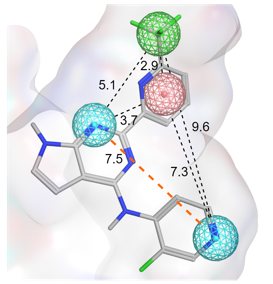

# show 2d molecule with atom index

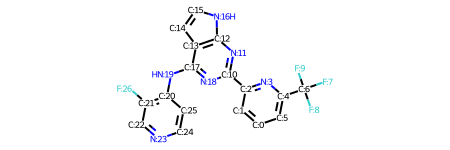

In [3]:
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

smiles='C1=CC(=NC(=C1)C(F)(F)F)C2=NC3=C(C=CN3)C(=N2)NC4=C(C=NC=C4)F'
mol=Chem.MolFromSmiles(smiles)
mol_with_atom_index( mol )

# preprocess ligand extract pharmacophore 

In [22]:
import os
from rdkit import Chem
import pandas as pd
import numpy as np
import random
import torch
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
import dgl
def sample_probability(elment_array,plist,N):
    Psample=[]
    n=len(plist)
    index=int(random.random()*n)
    mw=max(plist)
    beta=0.0
    for i in range(N):                  ##核心算法
        beta=beta+random.random()*2.0*mw
        while beta > plist[index]:
            beta=beta-plist[index]
            index=(index+1)%n
        Psample.append(elment_array[index])
    cresult=Counter(Psample)
    psam=[cresult[x] for x in plist]
    pe=[x*N for x in plist]
    #print(cresult)
    
    return Psample
def cal_dist(mol,start_atom,end_tom):
    list_=[]
    list_.append(start_atom)
    seen=set()
    seen.add(start_atom)
    parent={start_atom:None}
    nei_atom=[]
    bond_num = mol.GetNumBonds()
    while (len(list_)>0):    
        vertex=(list_[0])
        del(list_[0])
        nei_atom=([n.GetIdx() for n in mol.GetAtomWithIdx(vertex).GetNeighbors()])
        for w in nei_atom:
             if w not in seen:
                list_.append(w)
                seen.add(w)
                parent[w]=vertex
    path_atom=[]
    while end_tom!=None:
        path_atom.append(end_tom)
        end_tom=parent[end_tom]
    nei_bond=[]
    for i in range(bond_num):
        nei_bond.append((mol.GetBondWithIdx(i).GetBondType().name,mol.GetBondWithIdx(i).GetBeginAtomIdx(),mol.GetBondWithIdx(i).GetEndAtomIdx()))    
    bond_collection=[]    
    for idx in range(len(path_atom)-1):
        bond_start=path_atom[idx]
        bond_end=path_atom[idx+1]
        for bond_type in nei_bond:
            if len(list(set([bond_type[1],bond_type[2]]).intersection(set([bond_start,bond_end]))))==2:
                bond_=bond_type[0]
                if [bond_,bond_type[1],bond_type[2]] not in bond_collection:
                    bond_collection.append([bond_,bond_type[1],bond_type[2]])
    dist=0
    for elment in bond_collection:
        if elment[0]=='SINGLE':
            dist=dist+1
        elif elment[0]=='DOUBLE':
            dist=dist+0.87
        elif elment[0]=='AROMATIC':
            dist=dist+0.91
        else:
            dist=dist+0.78
    return dist


ELEM_LIST = [[1],[2],[3],[4],[5],[6],[0]]

def _onek_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def _atom_features(atom):
    return (torch.HalfTensor(_onek_encoding_unk(atom, ELEM_LIST)))

def ligand_to_pharmacophore(smiels,unique_index_filter_sort):
    dgl_list=[]
    mol=Chem.MolFromSmiles(smiles)
    unique_index_filter_sort=[[[2], (6,)],[[1], (0, 1, 2, 3, 4, 5)],[[3], (11,)],[[3], (23,)]]

    type_list=[]
    size_=[]
    e_list=[]
    position_matrix=np.zeros((len(unique_index_filter_sort),len(unique_index_filter_sort)))
    for mol_phco_i in range(len(unique_index_filter_sort)):
        mol_phco_i_elment=list(unique_index_filter_sort[mol_phco_i][1])
        if type(unique_index_filter_sort[mol_phco_i][0])==list:
            type_list.append(_atom_features(unique_index_filter_sort[mol_phco_i][0]))##是一个列表
        else:
            type_list.append(_atom_features([unique_index_filter_sort[mol_phco_i][0]]))

        size_.append(len(mol_phco_i_elment))
        e_list.append(mol_phco_i_elment)
        for mol_phco_j in range(len(unique_index_filter_sort)):
            mol_phco_j_elment=list(unique_index_filter_sort[mol_phco_j][1])
            if mol_phco_i_elment==mol_phco_j_elment:
                position_matrix[mol_phco_i,mol_phco_j]=0
            elif str(set(mol_phco_i_elment).intersection(set(mol_phco_j_elment)))=='set()':
                dist_set=[]
                for atom_i in mol_phco_i_elment:
                    for atom_j in mol_phco_j_elment:
                        dist=cal_dist(mol,atom_i,atom_j)
                        dist_set.append(dist)
                min_dist=min(dist_set)
                if max(len(mol_phco_i_elment),len(mol_phco_j_elment))==1:
                    position_matrix[mol_phco_i,mol_phco_j]=min_dist
                else:
                    position_matrix[mol_phco_i,mol_phco_j]=min_dist+max(len(mol_phco_i_elment),len(mol_phco_j_elment))*0.2
            else:
                for type_elment_i in mol_phco_i_elment:
                    for type_elment_j in mol_phco_j_elment:
                        if type_elment_i==type_elment_j:
                            position_matrix[mol_phco_i,mol_phco_j]=max(len(mol_phco_i_elment),len(mol_phco_j_elment))*0.2
                        ##以上是对两药效团直接有元素交集的情况总结。

    weights=[]
    u_list=[]
    v_list=[]
    phco_single=[]

    for u in range(position_matrix.shape[0]):
        for v in range(position_matrix.shape[1]):
            if u!=v:
                u_list.append(u)
                v_list.append(v)
                weights.append(position_matrix[u,v])
    u_list_tensor=torch.tensor(u_list)
    v_list_tensor=torch.tensor(v_list)
    g=dgl.graph((u_list_tensor,v_list_tensor))
    g.edata['dist']=torch.HalfTensor(weights)
    type_list_tensor=torch.stack(type_list)
    g.ndata['type']=type_list_tensor
    g.ndata['size']=torch.HalfTensor(size_)

    dgl_list.append(g)
    return dgl_list




In [6]:
unique_index_filter_sort=[[[2], (6,)],[[1], (0, 1, 2, 3, 4, 5)],[[3], (11,)],[[3], (23,)]]
smiles='C1=CC(=NC(=C1)C(F)(F)F)C2=NC3=C(C=CN3)C(=N2)NC4=C(C=NC=C4)F'
g1=ligand_to_pharmacophore(smiles,unique_index_filter_sort)
gs=g1
for g in gs:
    a=g.ndata['type']
    g.ndata['h'] = torch.cat((a,g.ndata['size'].reshape(-1, 1)), dim=1).float()
    g.edata['h'] = g.edata['dist'].reshape(-1, 1).float()

In [8]:

gsx = gs*40
bgx = dgl.batch(gsx).to('cuda')



GEN_RESULT_DIR = OUTPUT_DIR
GEN_RESULT_DIR.mkdir(exist_ok=True)

LOGGER.info('[max sampling]')

LOGGER.info(f'resetting random seed...')
seed_torch(CFG.seed)

res = []
for _ in tqdm(range(5)):
    predictions = model.generate(bgx, random_sample=False)
    res.extend(tokenizer.get_text(predictions))

gen_result = einops.rearrange(np.array(res),'(a b)->a b',b=len(gs))
pd.DataFrame(gen_result).T.reset_index().to_csv(GEN_RESULT_DIR/f'result_ePharmaLib_example.csv',index=False)

del model
torch.cuda.empty_cache()

LOGGER.info('-----------------------------------------------')

[max sampling]
resetting random seed...


  0%|          | 0/5 [00:00<?, ?it/s]

-----------------------------------------------
